**Tutorial: Training a Convolutional Neural Network (CNN) with Three Hidden Layers on CIFAR-10 dataset using Mish Activation and AdamW Optimizer**

In this tutorial, we will walk through the steps of training a Convolutional Neural Network (CNN) on the CIFAR-10 dataset. Our CNN will have three hidden convolutional layers, all of which will utilize the Mish activation function. Note that we will not be using any pre-trained CNN models in this task, meaning we will start from scratch. Let's get started!


In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch.nn.init import kaiming_normal_
from torchvision.transforms import ToTensor
import pdb
import matplotlib.pyplot as plt
import numpy as np
from pytorch_lightning.callbacks import Callback

In this code snippet, we define a `CNN` class that inherits from `pl.LightningModule`, which is a module from PyTorch Lightning that simplifies the training process.

Inside the `CNN` class, we define the layers of the convolutional neural network. The network consists of three convolutional layers (`conv1`, `conv2`, `conv3`), each followed by Mish activation function. The `pool1` layer is a max-pooling layer, and `avgpool` is an adaptive average pooling layer. Finally, we have a fully connected layer (`fc`) with an output size of 10, representing the number of classes in the CIFAR-10 dataset.

The `init_weights` method initializes the weights of the network layers using appropriate initialization techniques for each type of layer.

The `forward` method defines the forward pass of the network, where input `x` is passed through the layers in a sequential manner.

The `on_train_start` method initializes a list (`loss_vals`) to store the training loss values.

The `training_step` method performs a forward pass and calculates the training loss.

The `training_epoch_end` method calculates the average training loss across all training steps in an epoch and logs it using `self.log`. It also appends the training loss value to the `loss_vals` list.

The `test_step` method performs a forward pass and calculates the test loss and accuracy.

The `configure_optimizers` method configures the AdamW optimizer with a learning rate of 0.001.

Overall, this code snippet defines the architecture of the CNN, implements the forward pass, initializes the weights, and sets up the training and testing procedures for the model using PyTorch Lightning.

In [2]:
class CNN(pl.LightningModule):
    def __init__(self):
        super().__init__()
        
        # Define the layers of the CNN
        self.conv1 = nn.Conv2d(3, 32, kernel_size=7, stride=1, padding=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, 10)
        
        # Initialize the weights of the network
        self.init_weights()
        
    def forward(self, x):
        # Define the forward pass of the network
        x = F.mish(self.conv1(x))
        x = self.pool1(x)
        x = F.mish(self.conv2(x))
        x = F.mish(self.conv3(x))
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
    def init_weights(self):
        # Initialize the weights of the network layers
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.zeros_(m.bias)
                
    def on_train_start(self):
        # Initialize a list to store the training loss values
        self.loss_vals = []
    
    def training_step(self, batch, batch_idx):
        # Perform a forward pass and calculate the training loss
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        return loss

    def training_epoch_end(self, outputs):
        # Calculate the average training loss across all training steps
        train_loss = torch.stack([x['loss'] for x in outputs]).mean()        
        # Log the training loss using self.log
        self.log('train_loss', train_loss, on_epoch=True)
        loss_vals.append(train_loss.item())
    
    def test_step(self, batch, batch_idx):
        # Perform a forward pass and calculate the test loss and accuracy
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        acc = (y_hat.argmax(1) == y).float().mean()
        self.log('test_loss', loss.item())
        self.log('test_acc', acc, prog_bar=True)
    
    def configure_optimizers(self):
        # Configure the optimizer
        optimizer = AdamW(self.parameters(), lr=0.001)
        return optimizer


In this code snippet, we create the CIFAR-10 train and test datasets with data transformations using the `CIFAR10` class from the torchvision library. The `CIFAR10` class represents the CIFAR-10 dataset and provides functionalities to load and preprocess the data.

For the train dataset, we set `train=True` to indicate that we want to load the training data. We also specify the `root` directory where the dataset will be downloaded and stored. If the dataset is already downloaded, it will not be re-downloaded due to the `download=True` argument. The `transform=ToTensor()` argument applies the `ToTensor()` transformation to convert the images and labels to PyTorch tensors.

Similarly, for the test dataset, we set `train=False` to indicate that we want to load the test data. The rest of the arguments remain the same.

Next, we create train and test data loaders using the `DataLoader` class from PyTorch. Data loaders provide an iterable over the dataset, allowing us to efficiently load data in batches during training and evaluation. In this case, we set the `batch_size` to 128, meaning that each iteration of the data loader will provide a batch of 128 samples. We shuffle the train data by setting `shuffle=True`, which randomly shuffles the samples in each epoch to ensure diverse training. For the test data loader, we don't specify the `shuffle` argument, so the test data will be loaded in the original order.

These data loaders are used in the training and testing procedures to iterate over the data in batches, enabling efficient processing and model training.

In [3]:
# Create CIFAR-10 train and test datasets with data transformations
train_data = CIFAR10(root='data/', train=True, download=True, transform=ToTensor())
test_data = CIFAR10(root='data/', train=False, download=True, transform=ToTensor())

# Create train and test data loaders
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128)


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data/
Files already downloaded and verified


In this code snippet, we create an instance of the `CNN` model by calling `CNN()`, which initializes an object of the `CNN` class defined earlier.

We also initialize an empty list `loss_vals` to store the training loss values during the training process.

Next, we create a PyTorch Lightning `Trainer` object by calling `pl.Trainer()` and pass in the desired settings. In this case, we set `accelerator='gpu'` to leverage GPU acceleration for faster training if a GPU is available. The `devices=1` argument specifies the number of GPUs to use (in this case, 1 GPU). We set `max_epochs=50` to train the model for a maximum of 50 epochs.

Finally, we fit the model to the training data using the `fit` method of the `trainer` object. The `fit` method trains the model for the specified number of epochs (`max_epochs`) using the provided training data loader (`train_loader`).

During the training process, the training loss values will be calculated and logged based on the implementation in the `training_step` and `training_epoch_end` methods of the `CNN` class. The `loss_vals` list will be populated with the training loss values for further analysis or visualization.

In [9]:
# Create an instance of the CNN model
model = CNN()

# Initialize a list to store the training loss values
loss_vals = []

# Create a PyTorch Lightning Trainer with specified settings
trainer = pl.Trainer(accelerator='gpu', devices=1, max_epochs=50)

# Fit the model to the training data using the trainer
trainer.fit(model, train_loader)


Training: 0it [00:00, ?it/s]

This code snippet allows you to visualize the training loss curve, showing how the training loss evolves over the epochs of training. It can be helpful in analyzing the training progress and identifying any patterns or trends in the model's learning.

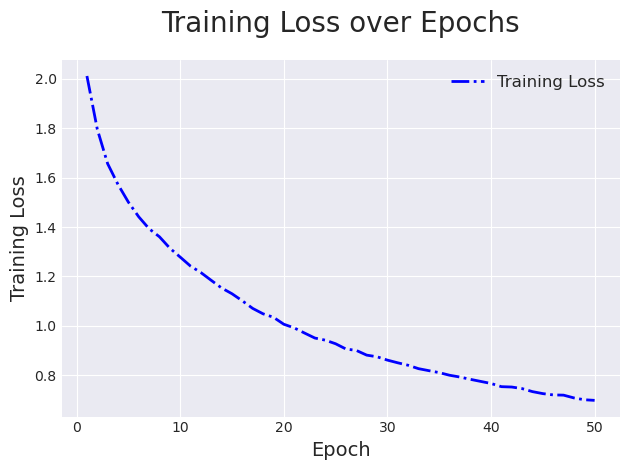

In [10]:
# Create a range of epochs
epochs = range(1, len(loss_vals) + 1, 1)

# setting style
plt.style.use('seaborn-darkgrid')

# plot command with additional parameters for line style and color
plt.plot(epochs, loss_vals, 'b-.', label='Training Loss', linewidth=2, markersize=12)

# labels
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Training Loss', fontsize=14)

# title
plt.title('Training Loss over Epochs', fontsize=20, pad=20)

# grid
plt.grid(True)

# legend
plt.legend(loc='upper right', fontsize=12)

# improving layout
plt.tight_layout()

# showing the plot
plt.show()


In this code snippet, we retrieve the weights of the filters in the `conv1` layer of the trained `model` by accessing the `conv1` layer's `weight` attribute. The `weight` attribute contains the filter weights in the form of a PyTorch tensor.

To work with the weights in NumPy, we use `cpu()` to move the tensor from GPU to CPU, and then convert it to a NumPy array using `.numpy()`. This allows us to perform NumPy operations on the array.

The resulting `conv1_filters` variable will contain the filter weights as a NumPy array on the CPU.

Finally, we determine the size of the `conv1_filters` array using the `.size` attribute. The `.size` attribute returns the total number of elements in the array, representing the size of the `conv1_filters` array.

This code snippet enables you to access and analyze the filter weights in the `conv1` layer of the CNN model, providing insights into the learned representations at that specific layer.

In [12]:
# Get the weights of the conv1 layer filters and convert them to a NumPy array on CPU
conv1_filters = model.conv1.weight.data.cpu().numpy()

# Get the size of the conv1_filters array
conv1_filters.size


4704

In this code snippet, we perform further processing on the `conv1_filters` array, which contains the filter weights of the `conv1` layer in the CNN model.

First, we compute the infinity norm (maximum absolute value) of the flattened `conv1_filters` array using `np.linalg.norm` function. The `reshape(-1)` operation flattens the array, and `ord=np.inf` specifies that we want to compute the infinity norm.

Next, we normalize the filter weights in the `conv1_filters` array using the computed infinity norm and an epsilon value for numerical stability. The normalization is done by dividing each element of the array by `2 * (norm_inf + epsilon)` and then adding `0.5` to shift the values to the range [0, 1].

Finally, we transpose the normalized filter array `conv1_filters_normalized` using `np.transpose`. The `(0, 2, 3, 1)` argument specifies the desired ordering of dimensions. This is necessary because, in PyTorch, the filter weights are typically stored in the format `(out_channels, in_channels, kernel_height, kernel_width)`, while in NumPy, it is common to use `(kernel_height, kernel_width, in_channels, out_channels)` ordering. The transpose operation ensures that the dimensions of the normalized filter array are ordered correctly for visualization or further analysis.

These additional steps in the code snippet compute the infinity norm of the filter weights, normalize the filter weights, and adjust the dimensions of the filter array to facilitate visualization or analysis of the filters.

In [13]:
# Compute the infinity norm of the flattened conv1_filters array
norm_inf = np.linalg.norm(conv1_filters.reshape(-1), ord=np.inf)

# Normalize the filter weights using the norm_inf and epsilon
epsilon = 0.0001
conv1_filters_normalized = (conv1_filters / (2 * (norm_inf + epsilon))) + 0.5

# Transpose the normalized filter array to match the expected dimension ordering
conv1_filters = np.transpose(conv1_filters_normalized, (0, 2, 3, 1))


In this code snippet, we create a figure and subplots to visualize the filters in the `conv1` layer of the CNN model.

We use `plt.subplots` to create a grid of subplots, with 4 rows and 8 columns, resulting in a total of 32 subplots. The `figsize` argument sets the size of the figure to (16, 8) inches. `fig.subplots_adjust` adjusts the spacing between subplots by setting the height and width spacing.

We then iterate over the filters using nested loops. The variable `idx` is calculated to determine the index of each filter in the `conv1_filters` array based on its position in the subplot grid. We access the filter using `conv1_filters[idx]` and display it in the corresponding subplot using `ax[i, j].imshow`.

We also configure the subplots by turning off the axes (`ax[i, j].axis('off')`) and setting a title for each subplot indicating the filter number (`ax[i, j].set_title(f'Filter {idx+1}')`).

Finally, we use `plt.show()` to display the plot containing the visualization of the filters.

This code snippet allows you to visualize the learned filters in the `conv1` layer of the CNN model, providing insights into the patterns and features the filters are capturing at that specific layer.

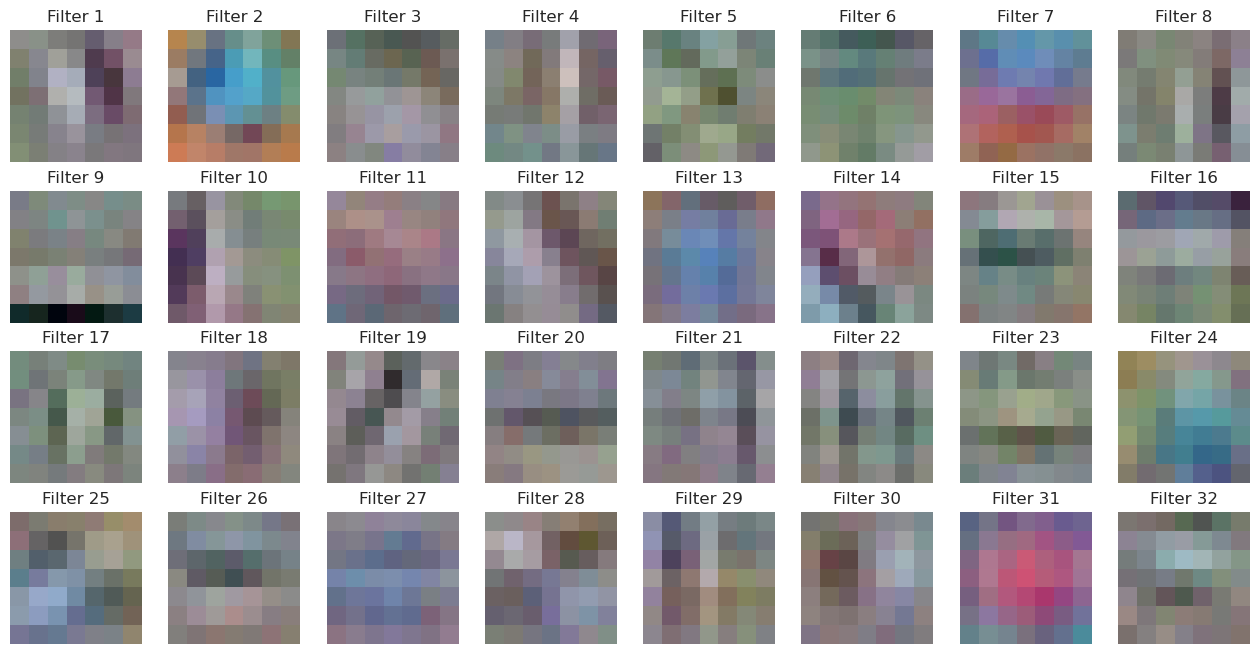

In [14]:
# Create subplots for visualization
fig, ax = plt.subplots(4, 8, figsize=(16, 8))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

# Iterate over the filters and display them in the subplots
for i in range(4):
    for j in range(8):
        idx = i * 8 + j
        ax[i, j].imshow(conv1_filters[idx])
        ax[i, j].axis('off')
        ax[i, j].set_title(f'Filter {idx+1}')

# Show the plot
plt.show()


This code snippet allows you to assess the performance of the trained model on unseen test data, providing insights into how well the model generalizes to new samples.

In [15]:
trainer.test(model,dataloaders=test_loader)

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7275999784469604     │
│         test_loss         │    0.7837559580802917     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.7837559580802917, 'test_acc': 0.7275999784469604}]

Congratulations! You have just trained a CNN with three hidden convolutional layers using the Mish activation function.